# BAKGRUND

#### BEHOV
* Redaktionen vill förstå när och hur läsare är som mest engagerade och aktiva digitalt.
* Det driver bland annat deras publiceringsmönster och konverteringsstrategi.
* Vill gärna få det nedbrutet på sektionsnivå så att det kan driva avdelningarnas individuella redaktionella strategi. 
* Dels vill man se absoluta tal, dels relativt en föregående period för att se om läsbeteenden har förändrats.

#### PROBLEM
* Vi tittar periodiskt på detta - ungefär två gånger om året. 
* Kräver ofta stor handpåläggning att hämta, bearbeta och visualisera datat - väldigt manuellt arbete.
* Metoden kan variera - ex. hur vi sållar ut outliers, justerar för inflation/deflation i jämförelsen mellan perioder.

#### LÖSNING 
* Gör en semi-automatisk notebook som spottar ut graferna vi vill ha genom en konsekvent metod. 
* Detta minskar det manuella arbetet och ökar flexibiliteten att möta mer spontana behov. 
* Det gör också att vi kan förbättra metoden över tid. 
* Förhoppningsvis kan detta dessutom användas av flera varumärken - och fler ögon kommer göra koden väsentligt bättre.
* Väldigt lättanpassat för data som finns i Reynolds.

#### OBS!
* Det finns säkerligen förbättringspotential i detta - all feedback uppskattas!
* Finns på Github under reading-heatmaps

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import normalize
from datetime import datetime

# Special functions for this purpose
from functions import date_check, transform_weekday, normalise_weeks, detect_outlier, remove_outliers, standard_pivot, comparison_pivot, pivot_method, filter_params, heatmap

In [2]:
# PROBLEMS
    # Comparisons produce some unexpected (i.e. hard-to-believe) inflation numbers.
    # It would be nice to look at "qualitative" article pageviews only - that last longer than 10 seconds.
    
# TO DO    
    # Add timelines
    # Add purchases

# 1. SET-UP

#### What you need to decide prior to running the notebook:
* The date range you want to examine. 
* An older date range if you want to make a comparison.
* If you want to examine browsers or accounts.

In [62]:
# SELECT THE APPROPRIATE DATA WAREHOUSE
PROJECT = 'data-warehouse-dn'

# SELECT A TIME PERIOD TO ANALYSE. (MAKE SURE IT IS MADE UP OF FULL WEEKS - USE THE FUNCTION BELOW). 
FROM_DATE = '2020-11-08'
TO_DATE = '2021-02-13' # 01-10

# SELECT A COMPARISON TIME PERIOD (PREFERABLY WITH COMPARABLE # OF WEEKS - ALTHOUGH WE WILL NORMALISE BY WEEK LATER).
FROM_DATE_COMP = '2019-11-08' # 11-08
TO_DATE_COMP = '2020-02-13' # 02-13

# SELECT UNIT OF ANALYSIS: EITHER BROWSERS OR ACCOUNTS.
ID = 'client_id' # user_id, client_id

# (We will use this later.)
dates = {
    'from_date': FROM_DATE,
    'to_date': TO_DATE,
    'from_date_comp': FROM_DATE_COMP,
    'to_date_comp': TO_DATE_COMP
}

#### Make sure there is an equal number of "day types" (e.g. Monday, Tuesday) in each date range - i.e. that you have selected "complete weeks." The code block below will check this for you.

In [63]:
print("CURRENT DATE RANGE")
date_check(from_date=FROM_DATE, to_date=TO_DATE) 
    
print("\nCOMPARISON DATE RANGE")
date_check(from_date=FROM_DATE_COMP, to_date=TO_DATE_COMP)

CURRENT DATE RANGE
Approved date range. Equal number of days of week.
Number of days: 98
Number of weeks: 14

COMPARISON DATE RANGE
Approved date range. Equal number of days of week.
Number of days: 98
Number of weeks: 14


# 2. IMPORT DATA

## 2.1 READING (PAGEVIEWS, MINUTES SPENT, USERS)

In [99]:
# SELECT GROUPING VARIABLE
GROUPING = 'referrer_category' # Total, section, device_category, login_status, referrer_category, data_source

# EXTRA: SELECT SECTION FILTER
    # If you use only one section, add '' symbols to the expression... 
SECTIONS = '("Kultur")'#'("Världen", "Sverige", "Ekonomi", "Kultur", "Sport", "STHLM", "Gbg", "Ledare", "DN Debatt", "Insidan")' # e.g. '("Kultur")' OR ("Nyheter", "Världen", "Sverige", "Ekonomi", "Kultur", "Sport", "STHLM", "Gbg", "Ledare", "DN Debatt", "Insidan")

In [100]:
def reading_query_text(from_date, to_date, grouping=GROUPING):
    
    if grouping == 'Total':
        GROUPING_QUERY_INPUT = '"Total" AS Total'
    else:
        GROUPING_QUERY_INPUT = GROUPING

    query = (f'''
    
                WITH active_duration AS (
                  SELECT
                    pageview_id,
                    SUM(SAFE_CAST(label AS INT64)) AS sum_time
                  FROM `data-warehouse-dn.reynolds.event` 
                  WHERE 1=1
                    AND action = 'Active Duration'
                    AND date BETWEEN "{from_date}" AND "{to_date}"
                  GROUP BY 1
                )

                SELECT 

                  # Groupings
                  pv.date,
                  EXTRACT(DAYOFWEEK FROM pv.date) AS weekday,
                  EXTRACT(HOUR FROM pv.timestamp AT TIME ZONE "Europe/Stockholm") AS hour, 
                  {GROUPING_QUERY_INPUT},

                  # KPIs
                  COUNT(DISTINCT pv.pageview_id) AS n_pageviews,
                  COUNT(DISTINCT
                    CASE WHEN LOWER(page_type) IN ("start page", "article list page") 
                    THEN pv.pageview_id ELSE NULL END) AS n_flak_pageviews, 
                  COUNT(DISTINCT
                    CASE WHEN LOWER(page_type) IN ("articlepage", "article page") 
                    THEN pv.pageview_id ELSE NULL END) AS n_article_pageviews, 
                  COUNT(DISTINCT
                    CASE WHEN ev.action = "Active Duration" AND LOWER(page_type) IN ("articlepage", "article page") AND SAFE_CAST(ev.label AS INT64) > 10000
                    THEN pv.pageview_id ELSE NULL END) AS n_real_article_pageviews,
                  COUNT(DISTINCT
                    CASE WHEN LOWER(page_type) IN ("articlepage", "article page") AND sum_time > 180000
                    THEN pv.pageview_id ELSE NULL END) AS n_longreads,
                  ROUND(SUM(DISTINCT
                    CASE WHEN ev.action = "Active Duration" 
                    THEN SAFE_CAST(ev.label AS INT64) ELSE NULL END
                    ) / 1000 / 60, 1) AS n_active_minutes,
                  ROUND(SUM(DISTINCT
                    CASE WHEN ev.action = "Active Duration" AND LOWER(page_type) IN ("articlepage", "article page") 
                    THEN SAFE_CAST(ev.label AS INT64) ELSE NULL END
                    ) / 1000 / 60, 1) AS n_active_article_minutes,
                  COUNT(DISTINCT pv.user_id) AS n_accounts,
                  COUNT(DISTINCT pv.client_id) AS n_browsers

                FROM `{PROJECT}.reynolds.pageview` pv 
                JOIN `{PROJECT}.reynolds.event` ev ON ev.date = pv.date AND ev.pageview_id = pv.pageview_id
                LEFT JOIN active_duration ad ON pv.pageview_id = ad.pageview_id

                WHERE 1=1
                  AND pv.date BETWEEN "{from_date}" AND "{to_date}"
                  AND sub_brand = "DNSE"
                  AND {ID} NOT IN ("", "N/A", "(not set)")
                  AND {ID} IS NOT NULL
                  AND section IN {SECTIONS}
                  AND content_id NOT LIKE "%dn.adhoc.%"
                  AND content_id NOT LIKE "%dn.ctf%"
                GROUP BY 1,2,3,4

            '''
            )
    
    return(query)

In [93]:
df = (
    pd.read_gbq(reading_query_text(from_date=FROM_DATE, to_date=TO_DATE, grouping='Total'), project_id=PROJECT)
)

df_comp = (
    pd.read_gbq(reading_query_text(from_date=FROM_DATE_COMP, to_date=TO_DATE_COMP, grouping='Total'), project_id=PROJECT)
)

Downloading: 100%|██████████| 1800/1800 [00:00<00:00, 4798.97rows/s]


In [94]:
df = remove_outliers(data=df, partition='Total')
df_comp = remove_outliers(data=df_comp, partition='Total')

# Aggregate the KPIs based on mean aggregation - since we want the average of each KPI per WEEK
kpis = {'n_pageviews':'mean',
        'n_flak_pageviews':'mean',
        'n_article_pageviews':'mean',
        'n_real_article_pageviews':'mean',
        'n_longreads':'mean',
        'n_active_minutes':'mean',
        'n_active_article_minutes':'mean',
        'n_browsers':'mean',
        'n_accounts':'mean'}

# Eliminate dates from data - group on weekday and hour (+ extra grouping)
df = df.groupby(['weekday', 'hour', 'Total']).aggregate(kpis).reset_index()
df_comp = df_comp.groupby(['weekday', 'hour', 'Total']).aggregate(kpis).reset_index()

transform_weekday(data=df)
transform_weekday(data=df_comp)


100.0% of original data remains.
100.0% of original data remains.


In [96]:
df['share_flak_pageviews'] = df.n_flak_pageviews / df.n_pageviews * 100
df['share_longreads'] = df.n_longreads / df.n_article_pageviews * 100
df['share_real_longreads'] = df.n_longreads / df.n_real_article_pageviews * 100
df['n_seconds_per_pageview'] = df.n_active_minutes / df.n_pageviews * 60
df['n_seconds_per_article_pageview'] = df.n_active_article_minutes / df.n_article_pageviews * 60

df_comp['share_flak_pageviews'] = df_comp.n_flak_pageviews / df_comp.n_pageviews * 100
df_comp['share_longreads'] = df_comp.n_longreads / df_comp.n_article_pageviews * 100
df_comp['share_real_longreads'] = df_comp.n_longreads / df_comp.n_real_article_pageviews * 100
df_comp['n_seconds_per_pageview'] = df_comp.n_active_minutes / df_comp.n_pageviews * 60
df_comp['n_seconds_per_article_pageview'] = df_comp.n_active_article_minutes / df_comp.n_article_pageviews * 60


In [101]:
df_reading = (
    pd.read_gbq(reading_query_text(from_date=FROM_DATE, to_date=TO_DATE, grouping=GROUPING), project_id=PROJECT)
)

df_reading_comp = (
    pd.read_gbq(reading_query_text(from_date=FROM_DATE_COMP, to_date=TO_DATE_COMP, grouping=GROUPING), project_id=PROJECT)
)

# Fix weekdays from numbers to words.
transform_weekday(data=df_reading)
transform_weekday(data=df_reading_comp)

Downloading: 100%|██████████| 7200/7200 [00:01<00:00, 6400.88rows/s]


In [102]:
# Outliers are removed by looking at pageviews by weekday, hour and the chosen grouping parameter - removing all that are beyond three standard deviation from the mean. 
df_reading = remove_outliers(data=df_reading, partition=GROUPING)
df_reading_comp = remove_outliers(data=df_reading_comp, partition=GROUPING)

94.0% of original data remains.
99.0% of original data remains.


In [103]:
# Aggregate the KPIs based on mean aggregation - since we want the average of each KPI per WEEK
kpis = {'n_pageviews':'mean',
        'n_flak_pageviews':'mean',
        'n_article_pageviews':'mean',
        'n_real_article_pageviews':'mean',
        'n_longreads':'mean',
        'n_active_minutes':'mean',
        'n_active_article_minutes':'mean',
        'n_browsers':'mean',
        'n_accounts':'mean'}

# Eliminate dates from data - group on weekday and hour (+ extra grouping)
df_reading = df_reading.groupby(['weekday', 'hour', f'{GROUPING}']).aggregate(kpis).reset_index()
df_reading_comp = df_reading_comp.groupby(['weekday', 'hour', f'{GROUPING}']).aggregate(kpis).reset_index()

In [104]:
# Add some new KPIs
df_reading['share_flak_pageviews'] = df_reading.n_flak_pageviews / df_reading.n_pageviews * 100
df_reading['share_longreads'] = df_reading.n_longreads / df_reading.n_article_pageviews * 100
df_reading['share_real_longreads'] = df_reading.n_longreads / df_reading.n_real_article_pageviews * 100
df_reading['n_seconds_per_pageview'] = df_reading.n_active_minutes / df_reading.n_pageviews * 60
df_reading['n_seconds_per_article_pageview'] = df_reading.n_active_article_minutes / df_reading.n_article_pageviews * 60

df_reading_comp['share_flak_pageviews'] = df_reading_comp.n_flak_pageviews / df_reading_comp.n_pageviews * 100
df_reading_comp['share_longreads'] = df_reading_comp.n_longreads / df_reading_comp.n_article_pageviews * 100
df_reading_comp['share_real_longreads'] = df_reading_comp.n_longreads / df_reading_comp.n_real_article_pageviews * 100
df_reading_comp['n_seconds_per_pageview'] = df_reading_comp.n_active_minutes / df_reading_comp.n_pageviews * 60
df_reading_comp['n_seconds_per_article_pageview'] = df_reading_comp.n_active_article_minutes / df_reading_comp.n_article_pageviews * 60


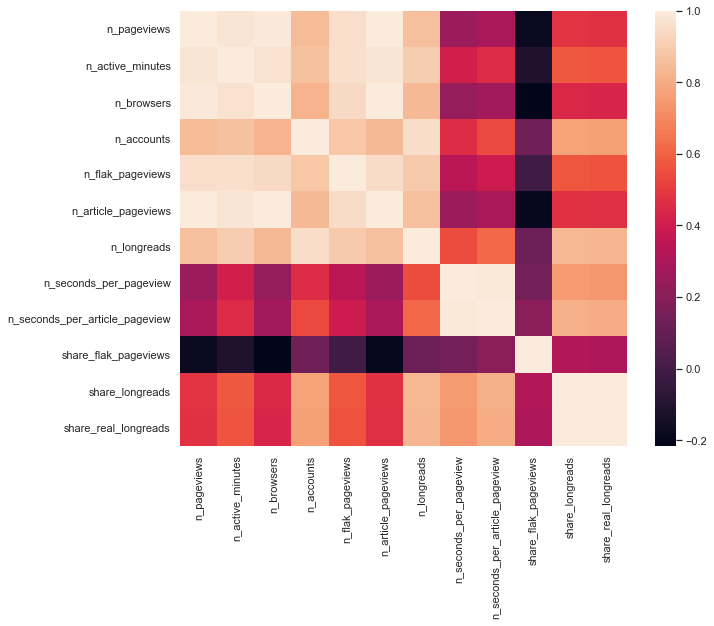

In [74]:
# Here we can see which KPIs correlate with each other - which helps us create insightful heatmaps
sns.set(rc={'figure.figsize':(10,8)})

sns.heatmap(df_reading[[
    'n_pageviews', 'n_active_minutes', 'n_browsers', 'n_accounts', 'n_flak_pageviews', 
    'n_article_pageviews', 'n_longreads', 'n_seconds_per_pageview', 'n_seconds_per_article_pageview',
    'share_flak_pageviews', 'share_longreads', 'share_real_longreads'
]].corr(method='spearman')); # spearman = rankkorrelation = nice på skev data

#plt.savefig(f'kpi_correlation_table.png', bbox_inches = "tight")

## 2.2 ARTICLE PUBLICATIONS AND PURCHASES

#### We do not filter for outliers here, in the same way that is done for consumer metrics. This is because publishing and purchasing is less variable.

In [44]:
def posting_query_text(from_date, to_date):

    query = f'''
    
                SELECT 
                  s.name AS section,
                  EXTRACT(DAYOFWEEK FROM publication_time AT TIME ZONE "Europe/Stockholm") AS weekday, # TEST REMOVE/ADD: AT TIME ZONE "Europe/Stockholm"
                  EXTRACT(HOUR FROM publication_time AT TIME ZONE "Europe/Stockholm") AS hour,
                  COUNT(DISTINCT art.identifier.id) AS n_publications,
                  #COUNT(DISTINCT pur.id) AS n_purchases 
                FROM `data-warehouse-dn.content.article` art,
                UNNEST(sections) s
                #LEFT JOIN `bn-analytics.orders.order_latest_norm` pur
                  #ON pur.article_id = art.identifier.id
                WHERE 1=1
                  AND art.publication_time BETWEEN "{from_date}" AND "{to_date}"
                  #AND pur.created_utc BETWEEN "{from_date}" AND "{to_date}" # Dates for when the purchases occured.
                  #AND DATE(created_sthlm_tz) BETWEEN "{from_date}" AND "{to_date}" # Dates for when the purchases occured.
                  AND s.name IN {SECTIONS}
                  #AND state = 'FULFILLED'
                  #AND flowtype IN ('PAYWALL','API')
                  #AND LOWER(payment_method) != 'trial'
                  #AND LOWER(payment_method) != 'prepaid'
                  #AND article_id NOT IN ('0', '')
                GROUP BY 1,2,3

            '''
    
    return(query)

In [45]:
df_posting = (
    pd.read_gbq(posting_query_text(from_date=FROM_DATE, to_date=TO_DATE), project_id=PROJECT)
)

df_posting_comp = (
    pd.read_gbq(posting_query_text(from_date=FROM_DATE_COMP, to_date=TO_DATE_COMP), project_id=PROJECT)
)

# Fix weekdays from numbers to words.
transform_weekday(data=df_posting)
transform_weekday(data=df_posting_comp)

# Normalise values based on # of weeks.
df_posting[['n_publications']] = normalise_weeks(from_date=FROM_DATE, to_date=TO_DATE, data=df_posting[['n_publications']])
df_posting_comp[['n_publications']] = normalise_weeks(from_date=FROM_DATE, to_date=TO_DATE, data=df_posting_comp[['n_publications']])

Downloading: 100%|██████████| 369/369 [00:00<00:00, 1191.62rows/s]


# 3. VISUALISE: HEATMAPS

#### The heatmaps function has a input variable "comp_data" referring to a comparable dataset. If you add a dataset to this variable, you can compare changes over time.

## 3.1 READING (PAGEVIEWS, MINUTES SPENT, USERS)

Parameter 'section' does not exist in the data.
Parameter 'section' does not exist in the data.
Parameter 'section' does not exist in the data.
Parameter 'section' does not exist in the data.


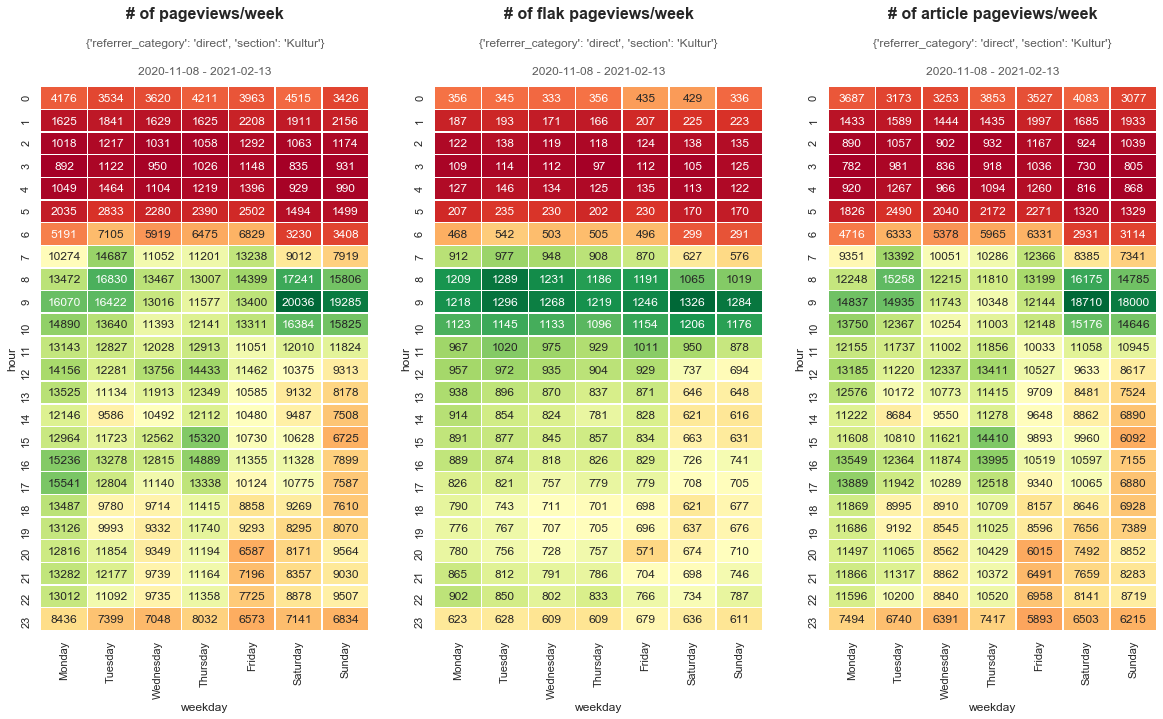

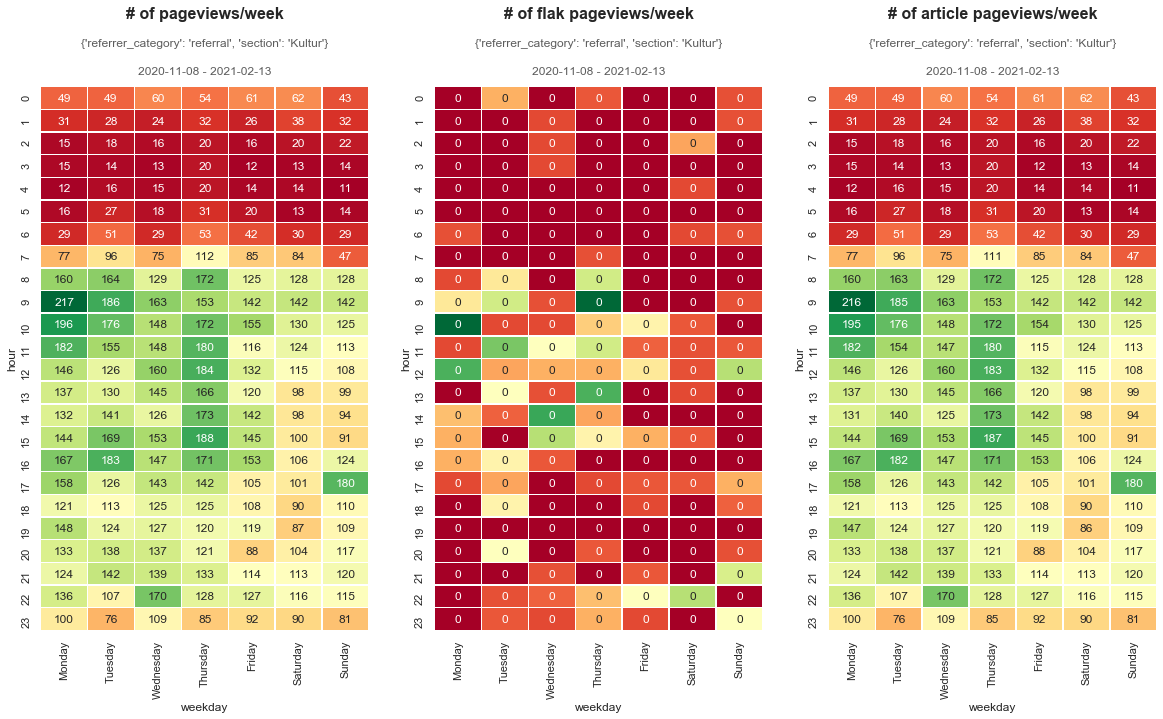

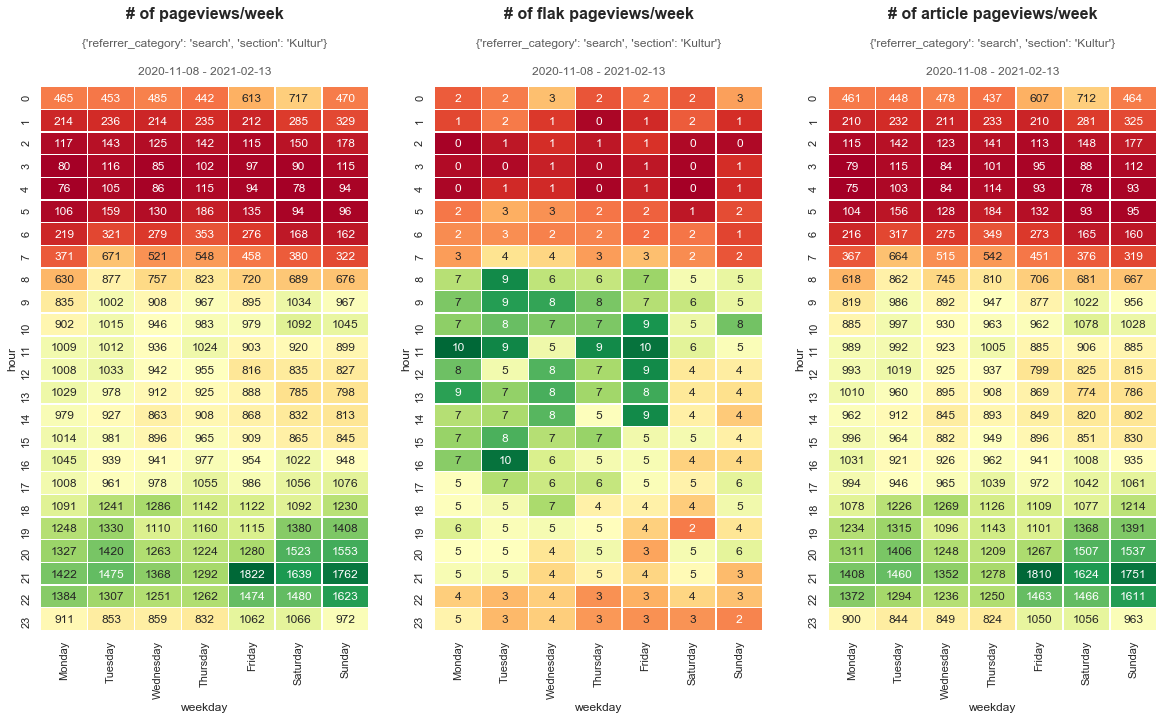

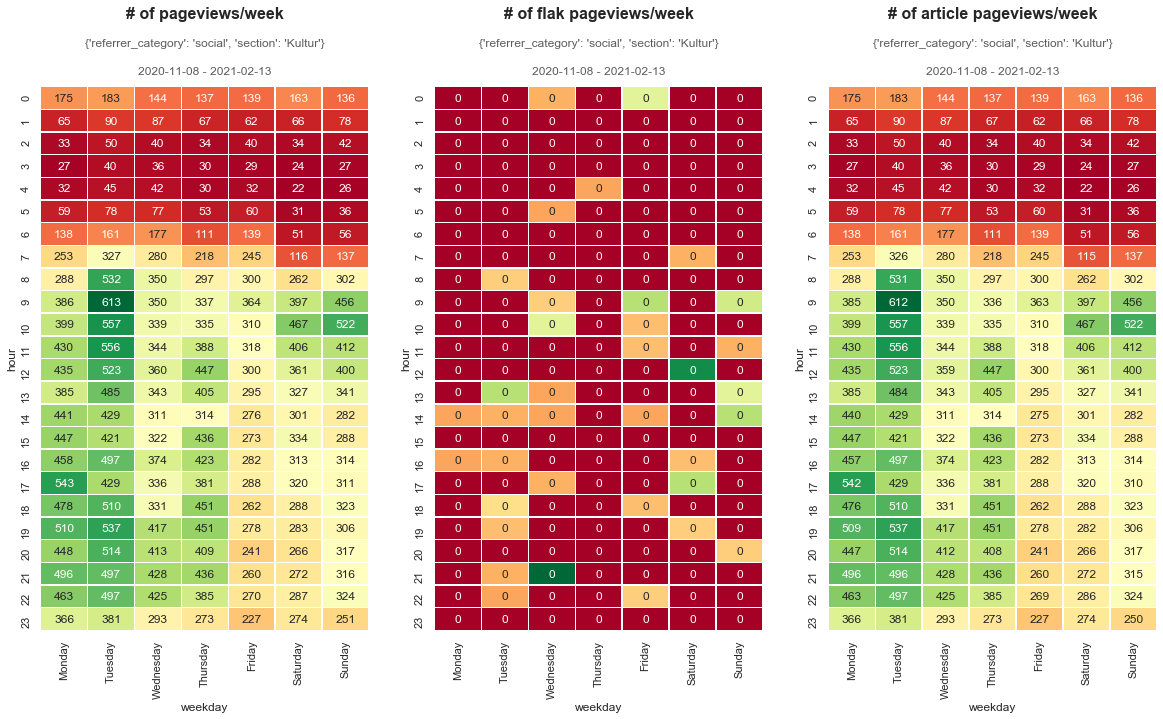

In [105]:
# Maximum three metrics!
metrics = {
    'n_pageviews': '# of pageviews/week',
    'n_flak_pageviews': '# of flak pageviews/week', 
    'n_article_pageviews': '# of article pageviews/week', 
}

# Select which sections to examine.
grouping_list = df_reading[f'{GROUPING}'].unique()

for val in grouping_list:
    
    # Select filtering parameters
    params = {
        f'{GROUPING}': f'{val}',
        'section': 'Kultur' # ONLY INCLUDE IF YOU WANT TO HIGHLIGHT CERTAIN SECTION
    }

    # Visualise behavioural heatmaps
    heatmap(params=params, 
            data=df_reading, 
            metrics=metrics,
            dates=dates); # add comp_data=df_reading_comp 
    
    #plt.savefig(f'{FROM_DATE}_pageviews_{TO_DATE}_{params}.png')
    #plt.savefig(f'{FROM_DATE}_pageviewscomp_{TO_DATE}_{params}.png')

Parameter 'section' does not exist in the data.
Parameter 'section' does not exist in the data.


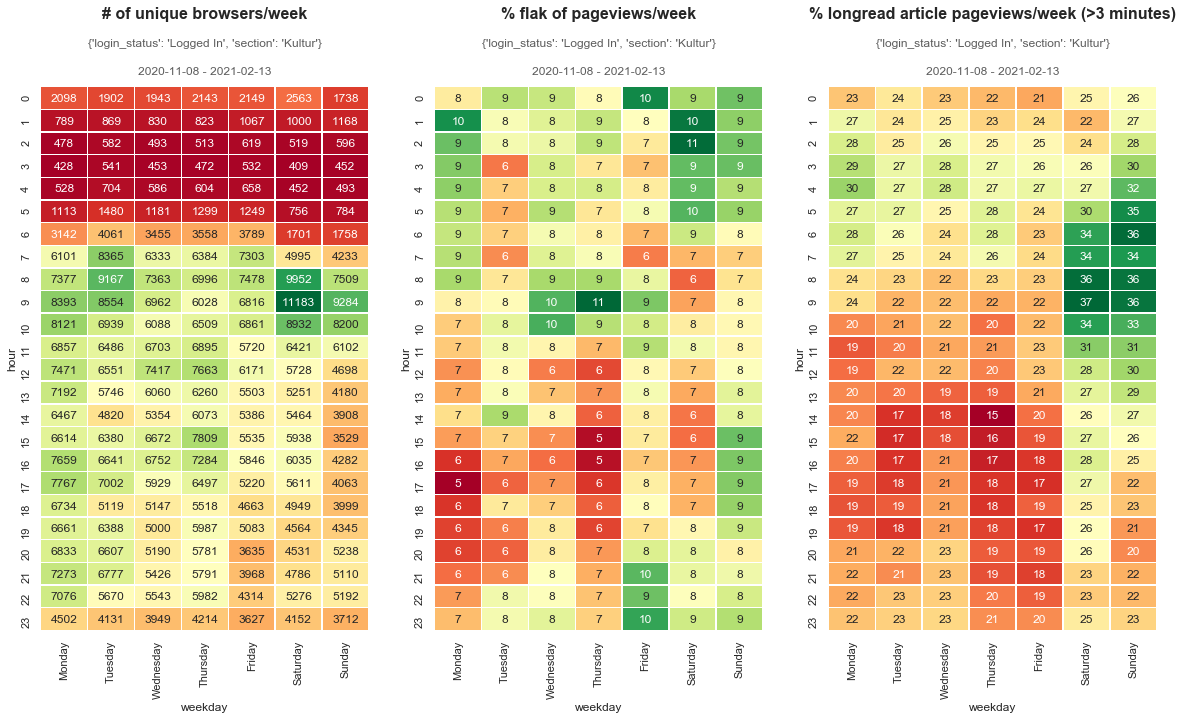

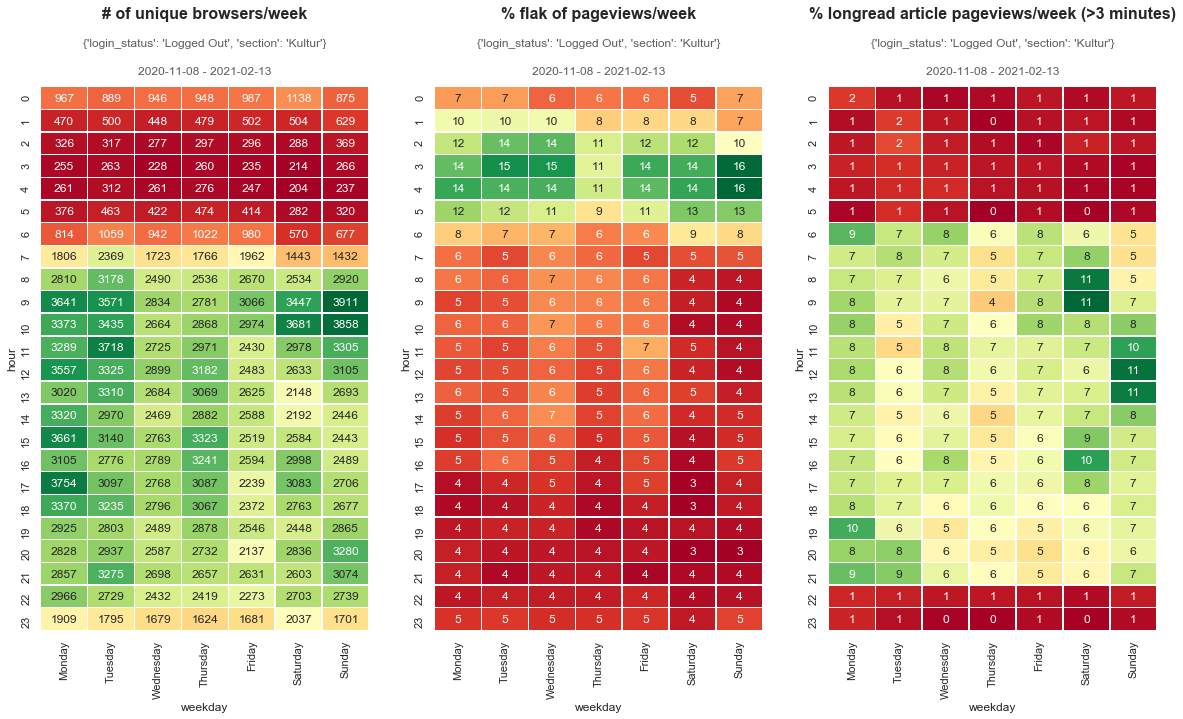

In [76]:
# Maximum three metrics!
metrics = {
    'n_browsers': '# of unique browsers/week',
    'share_flak_pageviews': '% flak of pageviews/week',
    'share_real_longreads': '% longread article pageviews/week (>3 minutes)'
}

# Select which sections to examine.
grouping_list = df_reading[f'{GROUPING}'].unique()

for val in grouping_list:
    
    # Select filtering parameters
    params = {
        f'{GROUPING}': f'{val}',
        'section': 'Kultur' # ONLY INCLUDE IF YOU WANT TO HIGHLIGHT CERTAIN SECTION
    }

    # Visualise behavioural heatmaps
    heatmap(params=params, 
            data=df_reading, 
            metrics=metrics,
            dates=dates); # add comp_data=df_reading_comp 

    #plt.savefig(f'{FROM_DATE}_engagement_{TO_DATE}_{params}.png')
    #plt.savefig(f'{FROM_DATE}_engagementcomp_{TO_DATE}_{params}.png')

## 3.2 ARTICLE PUBLICATIONS

In [48]:
df_posting_all = df_posting.groupby(['weekday', 'hour']).aggregate({'n_publications':'sum'}).reset_index()
df_posting_all_comp = df_posting_comp.groupby(['weekday', 'hour']).aggregate({'n_publications':'sum'}).reset_index()

Error: Only 6 weekdays are represented in the dataset.
Error: Only 6 weekdays are represented in the dataset.
Error: Only 0 weekdays are represented in the dataset.
Error: Only 5 weekdays are represented in the dataset.
Error: Only 6 weekdays are represented in the dataset.
Error: Only 6 weekdays are represented in the dataset.
Error: Only 6 weekdays are represented in the dataset.
Error: Only 6 weekdays are represented in the dataset.
Error: Only 6 weekdays are represented in the dataset.
Error: Only 6 weekdays are represented in the dataset.


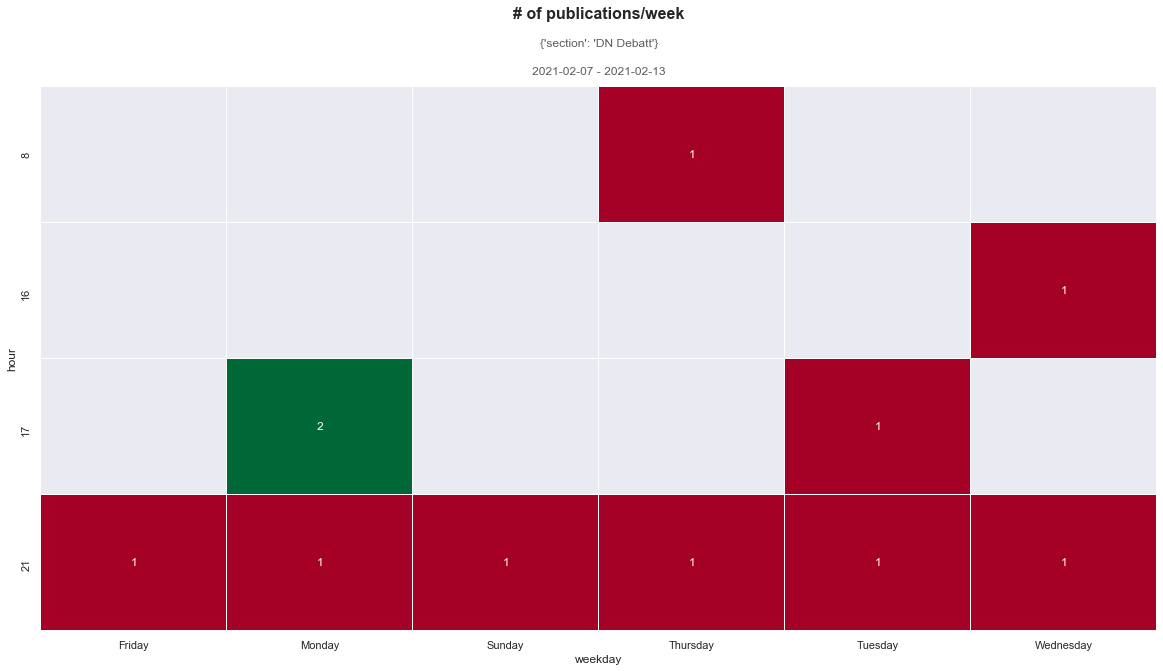

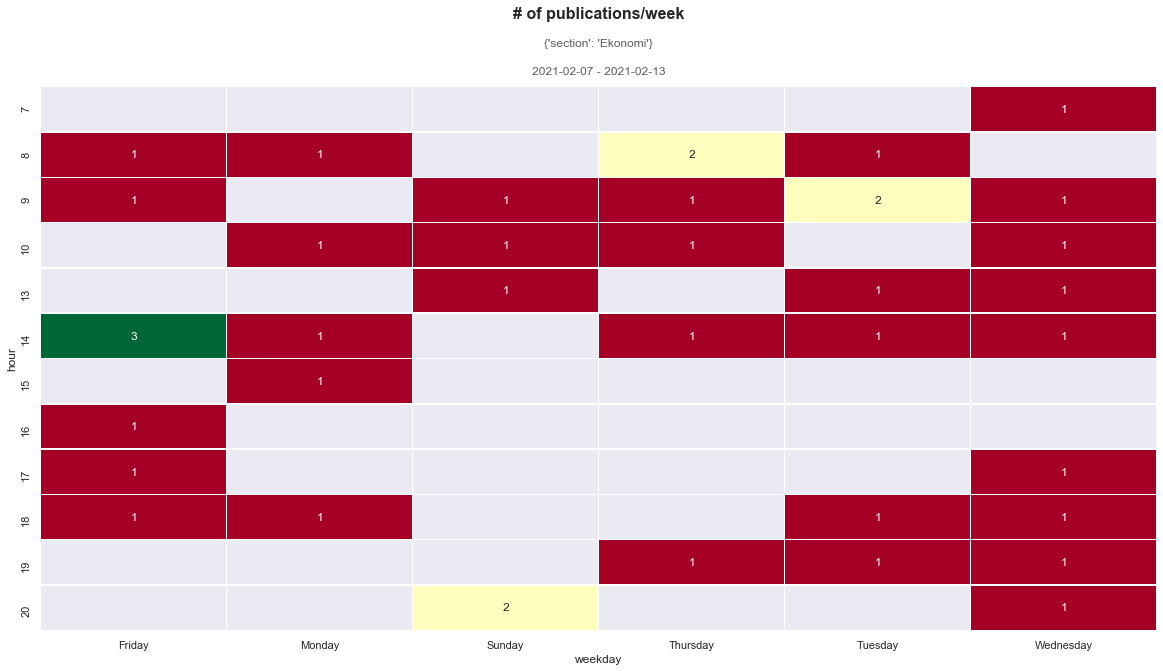

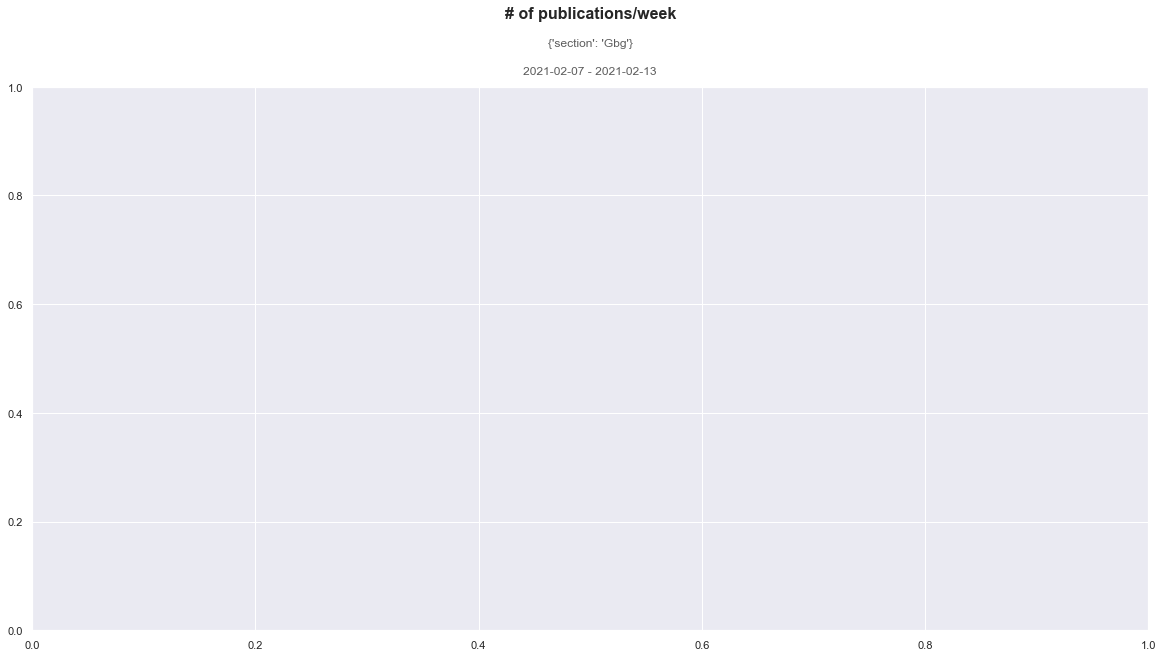

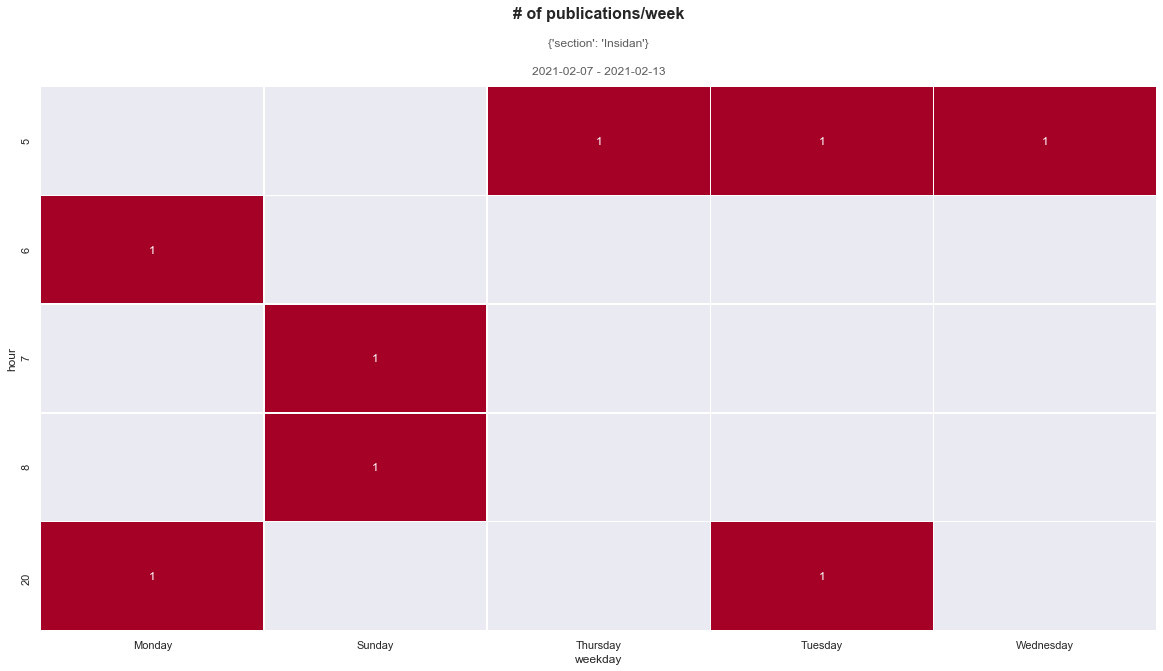

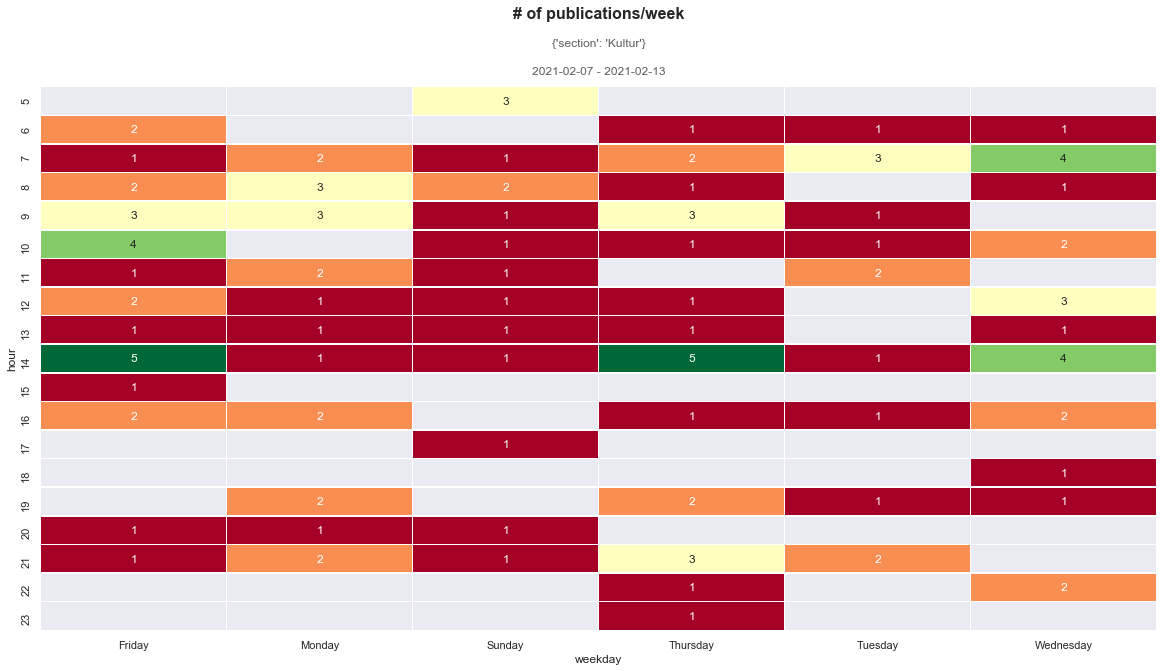

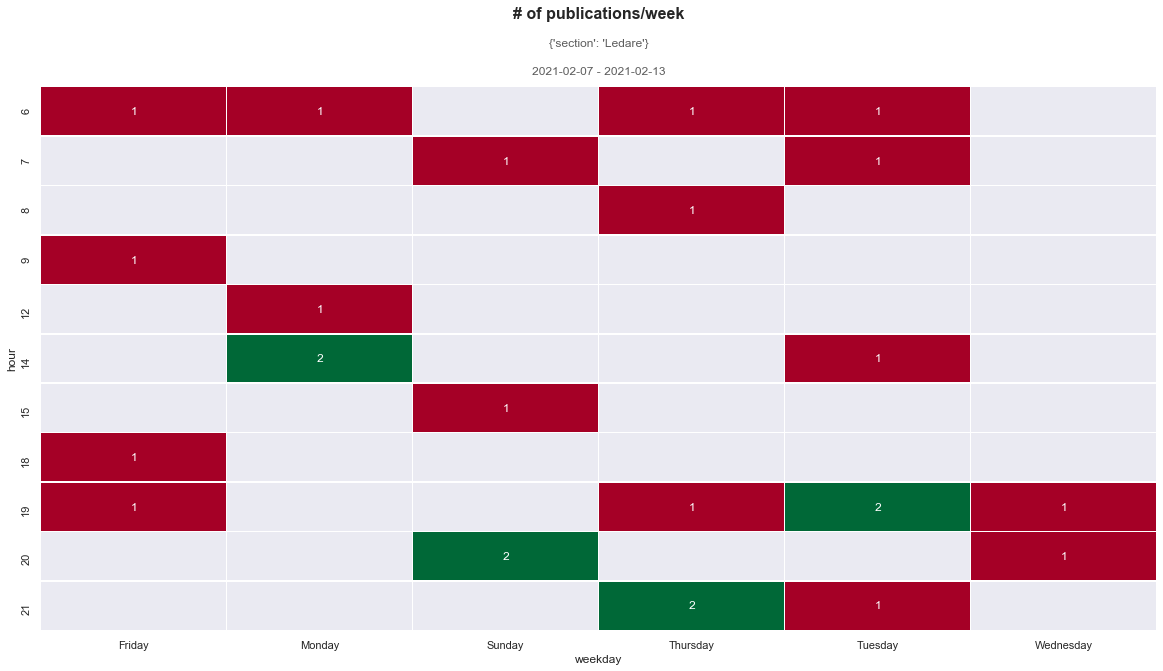

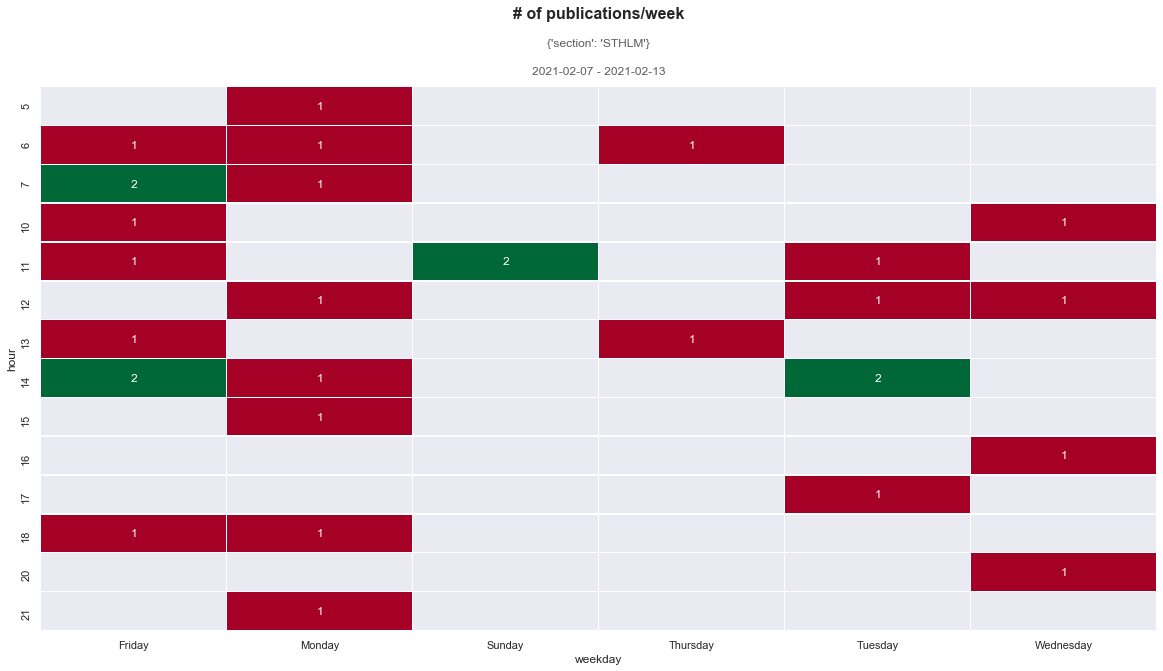

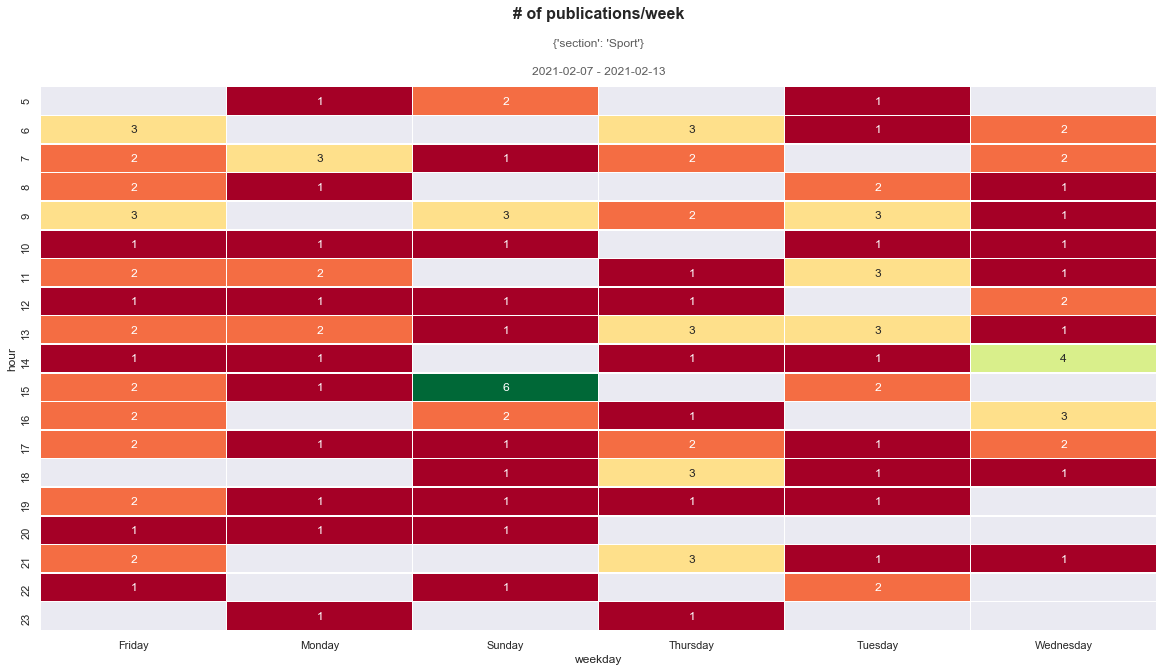

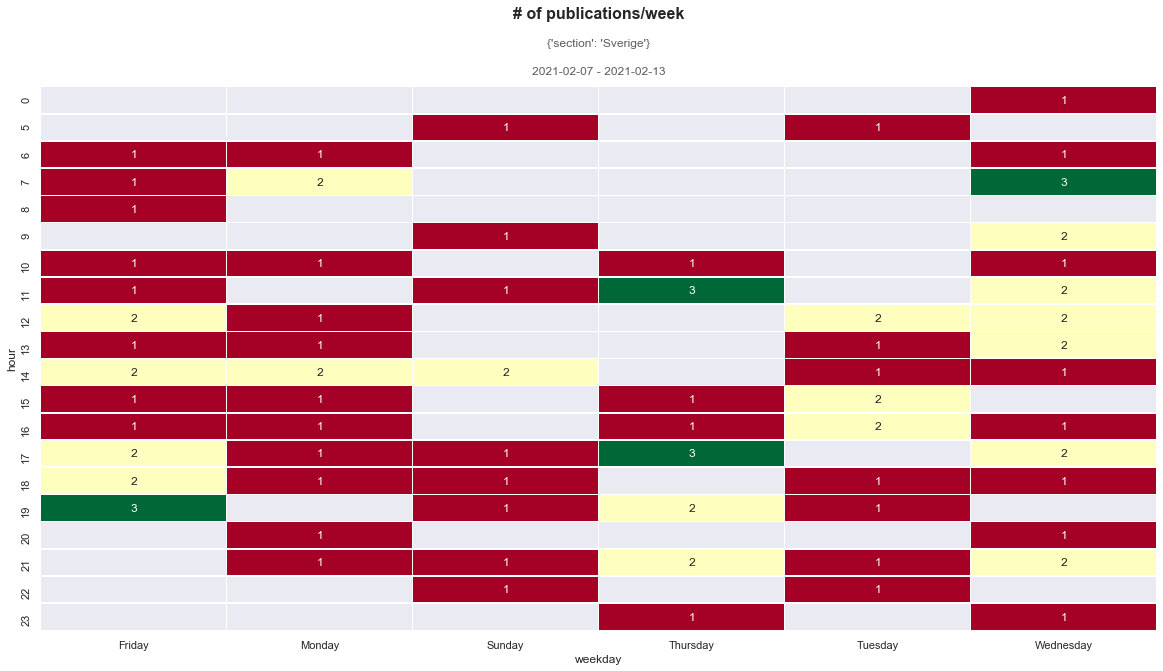

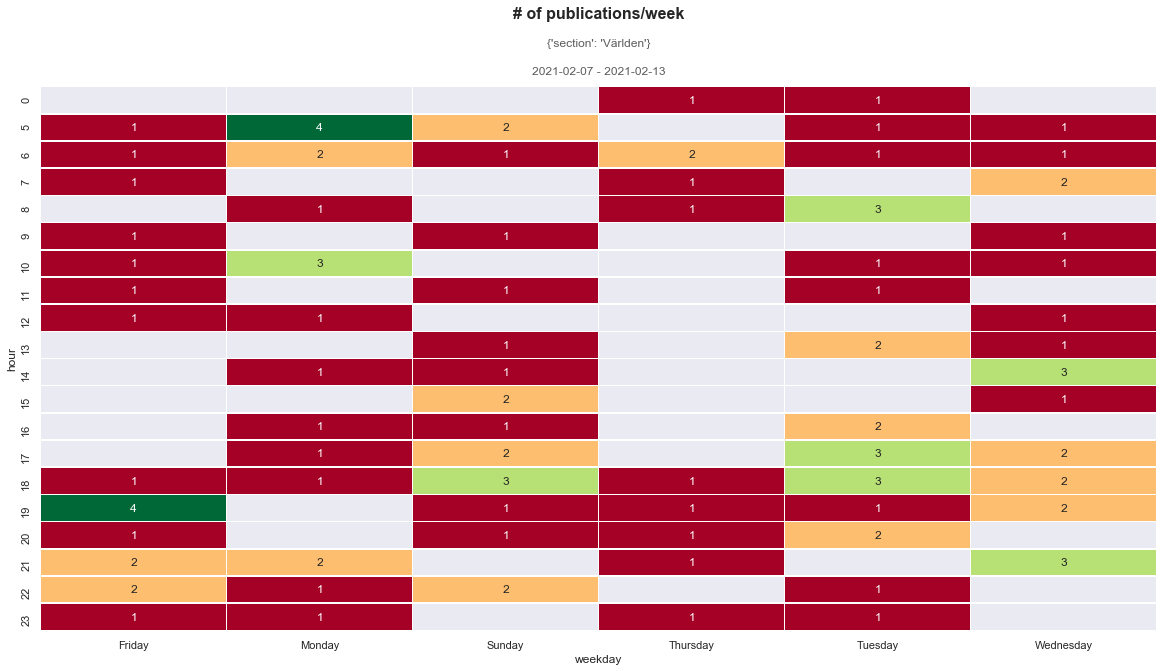

In [49]:
# Maximum three metrics!
metrics = {
    'n_publications': '# of publications/week',
    #'n_purchases': '# of purchases/week'
}

# Select which sections to examine.
grouping_list = df_reading[f'{GROUPING}'].unique()

for val in grouping_list:
    
    # Select filtering parameters
    params = {
        'section': f'{val}'
    }

    # Visualise behavioural heatmaps
    heatmap(params=params, 
            data=df_posting, 
            metrics=metrics,
            dates=dates); # add comp_data=df_posting_comp 

    #plt.savefig(f'{FROM_DATE}_posting_{TO_DATE}_{params}.png')
    #plt.savefig(f'{FROM_DATE}_postingcomp_{TO_DATE}_{params}.png')
    
    try: # If we insert no grouping parameter, don't loop unnecessarily. 
        params['section']
    except:
        break

# WIP

In [50]:
df

,weekday,hour,Total,n_pageviews,n_flak_pageviews,n_article_pageviews,n_real_article_pageviews,n_longreads,n_active_minutes,n_active_article_minutes,n_browsers,n_accounts,share_flak_pageviews,share_longreads,share_real_longreads,n_seconds_per_pageview,n_seconds_per_article_pageview
0,Sunday,0,Total,19887,880,18996,13229,2087,7880.0,7597.0,9780,5333,4.425001,10.986523,15.775947,23.774325,23.995578
1,Sunday,1,Total,15114,629,14479,9937,1674,5906.1,5689.4,7043,4095,4.161704,11.561572,16.846131,23.446209,23.576490
2,Sunday,2,Total,8451,380,8065,5605,1023,3631.2,3504.3,3768,2221,4.496509,12.684439,18.251561,25.780618,26.070428
3,Sunday,3,Total,6787,277,6507,4690,957,3112.8,3004.9,2868,1742,4.081332,14.707238,20.405117,27.518491,27.707699
4,Sunday,4,Total,7986,386,7596,5579,1093,3598.2,3445.5,3214,2006,4.833459,14.389152,19.591325,27.033809,27.215640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,Saturday,19,Total,68711,2992,65690,44916,6987,22732.4,22178.3,34995,21501,4.354470,10.636322,15.555704,19.850446,20.257239
164,Saturday,20,Total,65180,3282,61874,42740,7060,23123.7,22537.8,33867,20357,5.035287,11.410285,16.518484,21.286008,21.855190
165,Saturday,21,Total,87348,3315,84007,58355,8641,24447.0,23965.6,45769,30271,3.795164,10.286048,14.807643,16.792829,17.116859
166,Saturday,22,Total,86437,3174,83240,57026,8567,22229.2,21672.8,42162,28681,3.672039,10.291927,15.022972,15.430337,15.621913


In [51]:
df_reading

,weekday,hour,section,n_pageviews,n_flak_pageviews,n_article_pageviews,n_real_article_pageviews,n_longreads,n_active_minutes,n_active_article_minutes,n_browsers,n_accounts,share_flak_pageviews,share_longreads,share_real_longreads,n_seconds_per_pageview,n_seconds_per_article_pageview
0,Friday,0,DN Debatt,804,67,737,532,189,608.6,588.5,661,506,8.333333,25.644505,35.526316,45.417910,47.910448
1,Friday,0,Ekonomi,2682,205,2475,1598,240,974.2,915.3,1995,1305,7.643550,9.696970,15.018773,21.794183,22.189091
2,Friday,0,Gbg,30,30,0,0,0,14.4,NaN,24,17,100.000000,NaN,NaN,28.800000,NaN
3,Friday,0,Insidan,102,8,94,42,16,46.3,45.7,73,44,7.843137,17.021277,38.095238,27.235294,29.170213
4,Friday,0,Kultur,4097,404,3690,2281,258,1416.9,1308.9,2595,1620,9.860874,6.991870,11.310829,20.750305,21.282927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,Wednesday,23,Ledare,3327,124,3203,2532,212,1383.8,1347.9,2803,2183,3.727081,6.618795,8.372828,24.955816,25.249454
1676,Wednesday,23,STHLM,2245,177,2066,1491,363,1217.5,1163.8,1885,1439,7.884187,17.570184,24.346076,32.538976,33.798645
1677,Wednesday,23,Sport,2517,272,2244,1593,138,838.1,739.8,1553,1235,10.806516,6.149733,8.662900,19.978546,19.780749
1678,Wednesday,23,Sverige,8855,89,8766,5863,728,3421.6,3381.1,6861,3990,1.005082,8.304814,12.416851,23.184190,23.142368


In [52]:
test = pd.merge(df_reading, df, how='left', on=['weekday', 'hour'], suffixes=('_section','_total'))
test['share_article_pageviews'] = test.n_article_pageviews_section / test.n_article_pageviews_total
test['share_total_longreads'] = test.n_longreads_section / test.n_longreads_total
test.head(1)

,weekday,hour,section,n_pageviews_section,n_flak_pageviews_section,n_article_pageviews_section,n_real_article_pageviews_section,n_longreads_section,n_active_minutes_section,n_active_article_minutes_section,...,n_active_article_minutes_total,n_browsers_total,n_accounts_total,share_flak_pageviews_total,share_longreads_total,share_real_longreads_total,n_seconds_per_pageview_total,n_seconds_per_article_pageview_total,share_article_pageviews,share_total_longreads
0,Friday,0,DN Debatt,804,67,737,532,189,608.6,588.5,...,9660.1,14314,8667,4.152326,10.60661,15.753157,18.845938,19.098026,0.024284,0.058714


In [54]:
params = {'section':'Kultur'}

filtered_data = filter_params(data=test, params=params)

filtered_data = standard_pivot(data=filtered_data, value='share_article_pageviews')

filtered_data

weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
hour,,,,,,,
0,0.265537,0.108119,0.239177,0.232379,0.121586,0.132997,0.177037
1,0.191118,0.246427,0.116803,0.213775,0.243315,0.125282,0.157746
2,0.170422,0.254814,0.101369,0.206745,0.232894,0.110411,0.161438
3,0.178907,0.237198,0.110479,0.205132,0.265349,0.104636,0.140618
4,0.181911,0.240568,0.099617,0.213093,0.245143,0.100670,0.141127
5,0.143641,0.210331,0.082999,0.187697,0.221375,0.093108,0.193295
6,0.121518,0.154237,0.084780,0.162590,0.231986,0.075460,0.327671
7,0.129108,0.210772,0.132277,0.207654,0.257153,0.092143,0.314406
8,0.161335,0.208483,0.181581,0.236098,0.226946,0.112135,0.367918


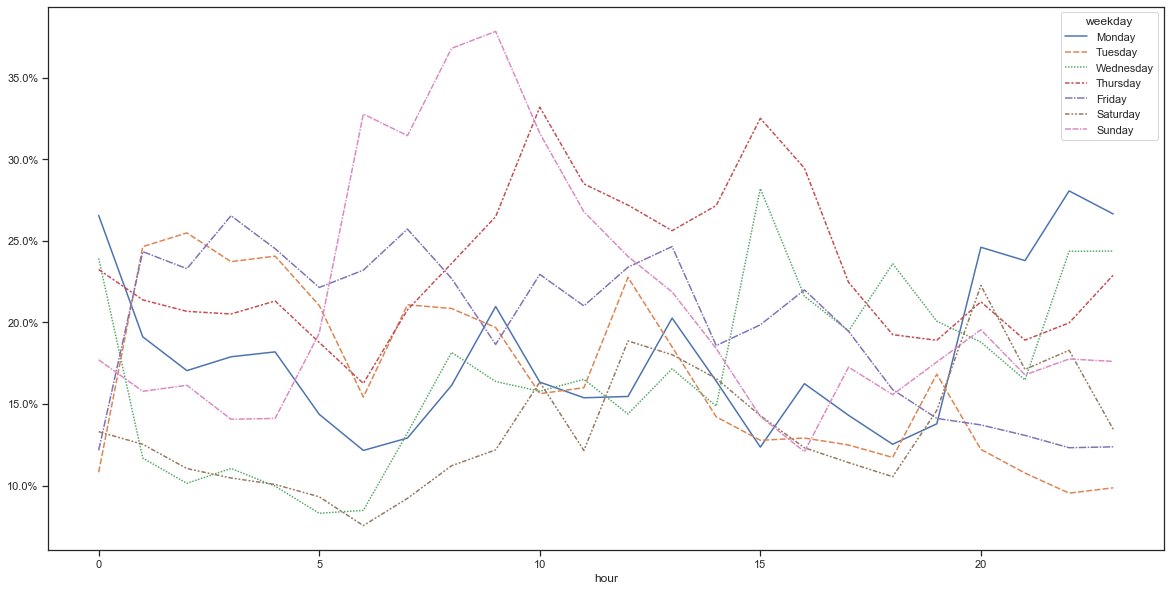

In [55]:
import matplotlib.ticker as mtick

sns.set(rc={'figure.figsize':(20,10)})

sns.set_style("ticks")

f, ax = plt.subplots()

sns.lineplot(data=filtered_data);

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [56]:
df = df.rename(columns={'Total': 'section'})

In [57]:
test = pd.concat([df_reading, df])
test

,weekday,hour,section,n_pageviews,n_flak_pageviews,n_article_pageviews,n_real_article_pageviews,n_longreads,n_active_minutes,n_active_article_minutes,n_browsers,n_accounts,share_flak_pageviews,share_longreads,share_real_longreads,n_seconds_per_pageview,n_seconds_per_article_pageview
0,Friday,0,DN Debatt,804,67,737,532,189,608.6,588.5,661,506,8.333333,25.644505,35.526316,45.417910,47.910448
1,Friday,0,Ekonomi,2682,205,2475,1598,240,974.2,915.3,1995,1305,7.643550,9.696970,15.018773,21.794183,22.189091
2,Friday,0,Gbg,30,30,0,0,0,14.4,NaN,24,17,100.000000,NaN,NaN,28.800000,NaN
3,Friday,0,Insidan,102,8,94,42,16,46.3,45.7,73,44,7.843137,17.021277,38.095238,27.235294,29.170213
4,Friday,0,Kultur,4097,404,3690,2281,258,1416.9,1308.9,2595,1620,9.860874,6.991870,11.310829,20.750305,21.282927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,Saturday,19,Total,68711,2992,65690,44916,6987,22732.4,22178.3,34995,21501,4.354470,10.636322,15.555704,19.850446,20.257239
164,Saturday,20,Total,65180,3282,61874,42740,7060,23123.7,22537.8,33867,20357,5.035287,11.410285,16.518484,21.286008,21.855190
165,Saturday,21,Total,87348,3315,84007,58355,8641,24447.0,23965.6,45769,30271,3.795164,10.286048,14.807643,16.792829,17.116859
166,Saturday,22,Total,86437,3174,83240,57026,8567,22229.2,21672.8,42162,28681,3.672039,10.291927,15.022972,15.430337,15.621913


In [58]:
filtered_data = (
    test.copy()
    .query('weekday.str.contains("Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday") & section.str.contains("Kultur|Ekonomi")', engine='python')
    .groupby(['hour', 'section'])
    .aggregate({'n_article_pageviews':'sum'})
    .reset_index()
)
    
filtered_data

,hour,section,n_article_pageviews
0,0,Ekonomi,10382
1,0,Kultur,27721
2,1,Ekonomi,5014
3,1,Kultur,13129
4,2,Ekonomi,3466
5,2,Kultur,8275
6,3,Ekonomi,3367
7,3,Kultur,8327
8,4,Ekonomi,4490
9,4,Kultur,10615


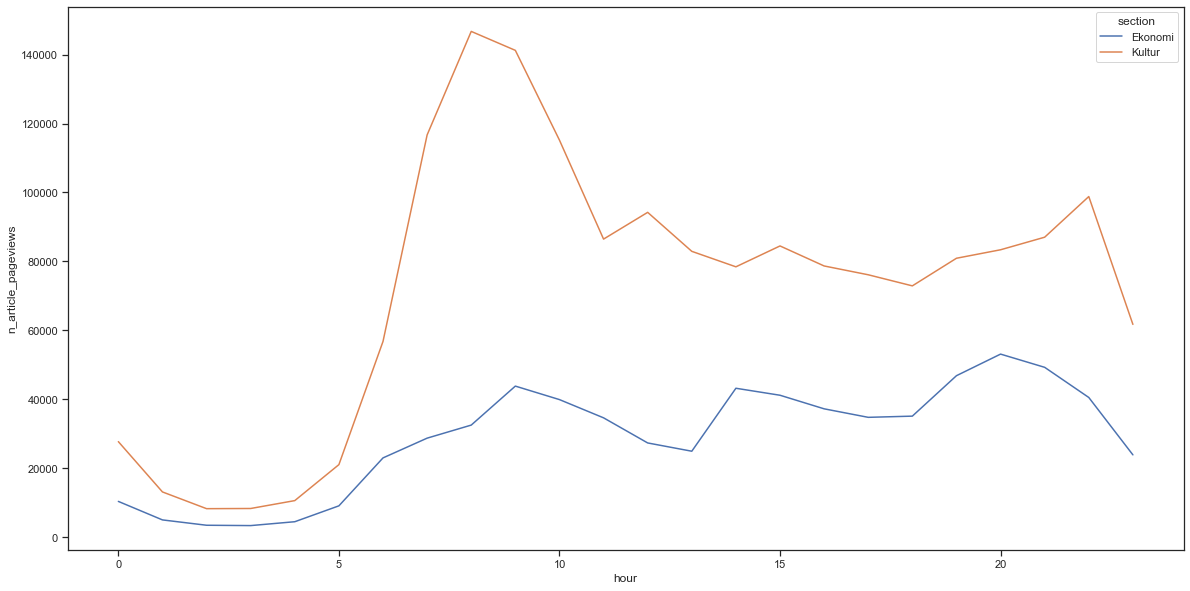

In [59]:
sns.set(rc={'figure.figsize':(20,10)})

sns.set_style("ticks")

#f, ax = plt.subplots()

sns.lineplot(data=filtered_data, x='hour', y='n_article_pageviews', hue='section');

#ax.yaxis.set_major_formatter(mtick.PercentFormatter()) # Add 1.0 to fix

In [60]:
filtered_data = (
    test.copy()
    .query('section.str.contains("Världen|Sverige")', engine='python')
)

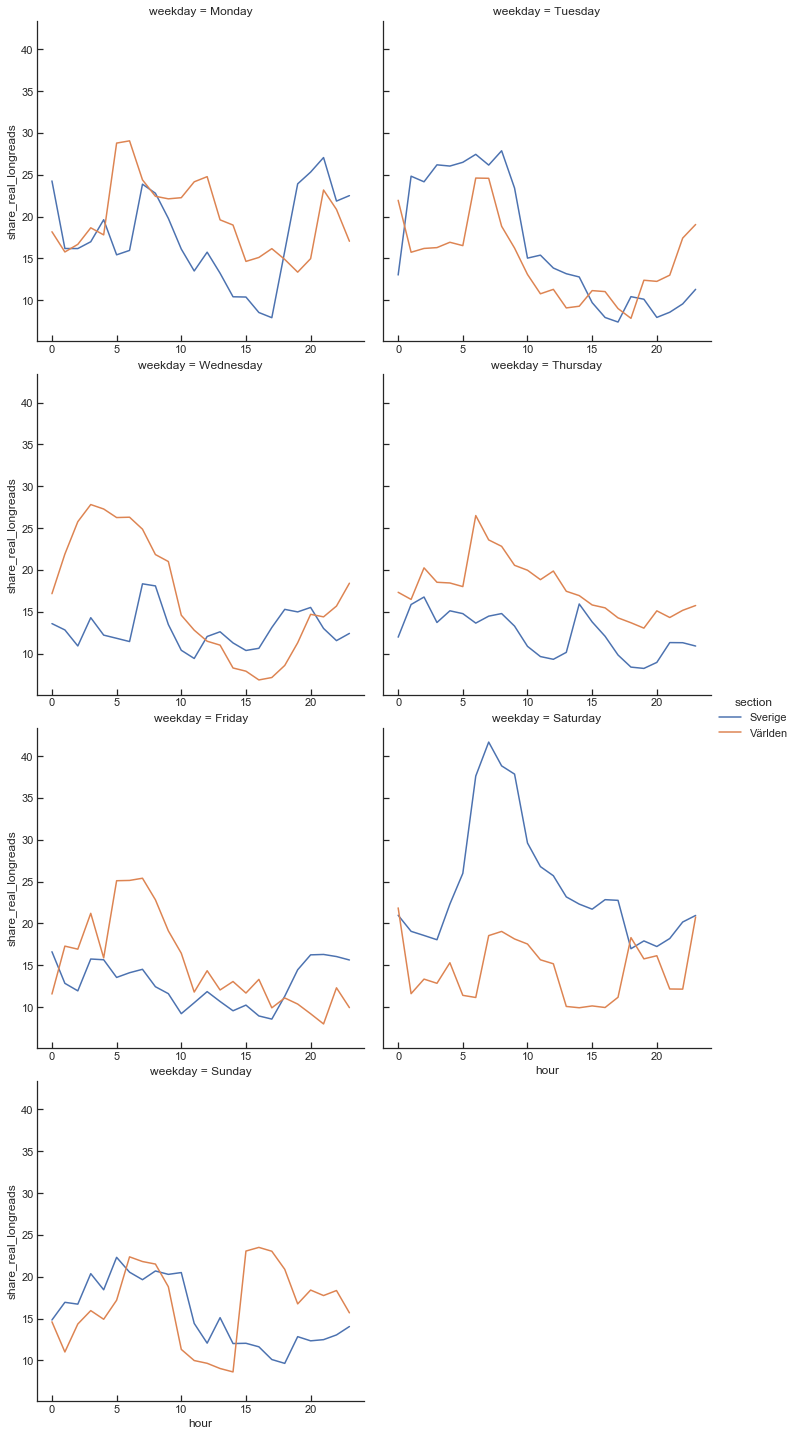

In [61]:
filtered_data['weekday'] = pd.Categorical(filtered_data['weekday'], ["Monday", 
                                                                     "Tuesday", 
                                                                     "Wednesday", 
                                                                     "Thursday", 
                                                                     "Friday", 
                                                                     "Saturday", 
                                                                     "Sunday"])

g = sns.relplot(
    data=filtered_data, x="hour", y="share_real_longreads",
    col="weekday", hue="section", kind="line", col_wrap=2
)

for ax in g.axes.flatten():
    ax.tick_params(direction='in', labelbottom=True)